Folder 'Results_from_the_Model' already exists!
LHAPDF 6.5.4 loading /home/ishara/LHAPDF/LHAPDF-install/share/LHAPDF/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331700


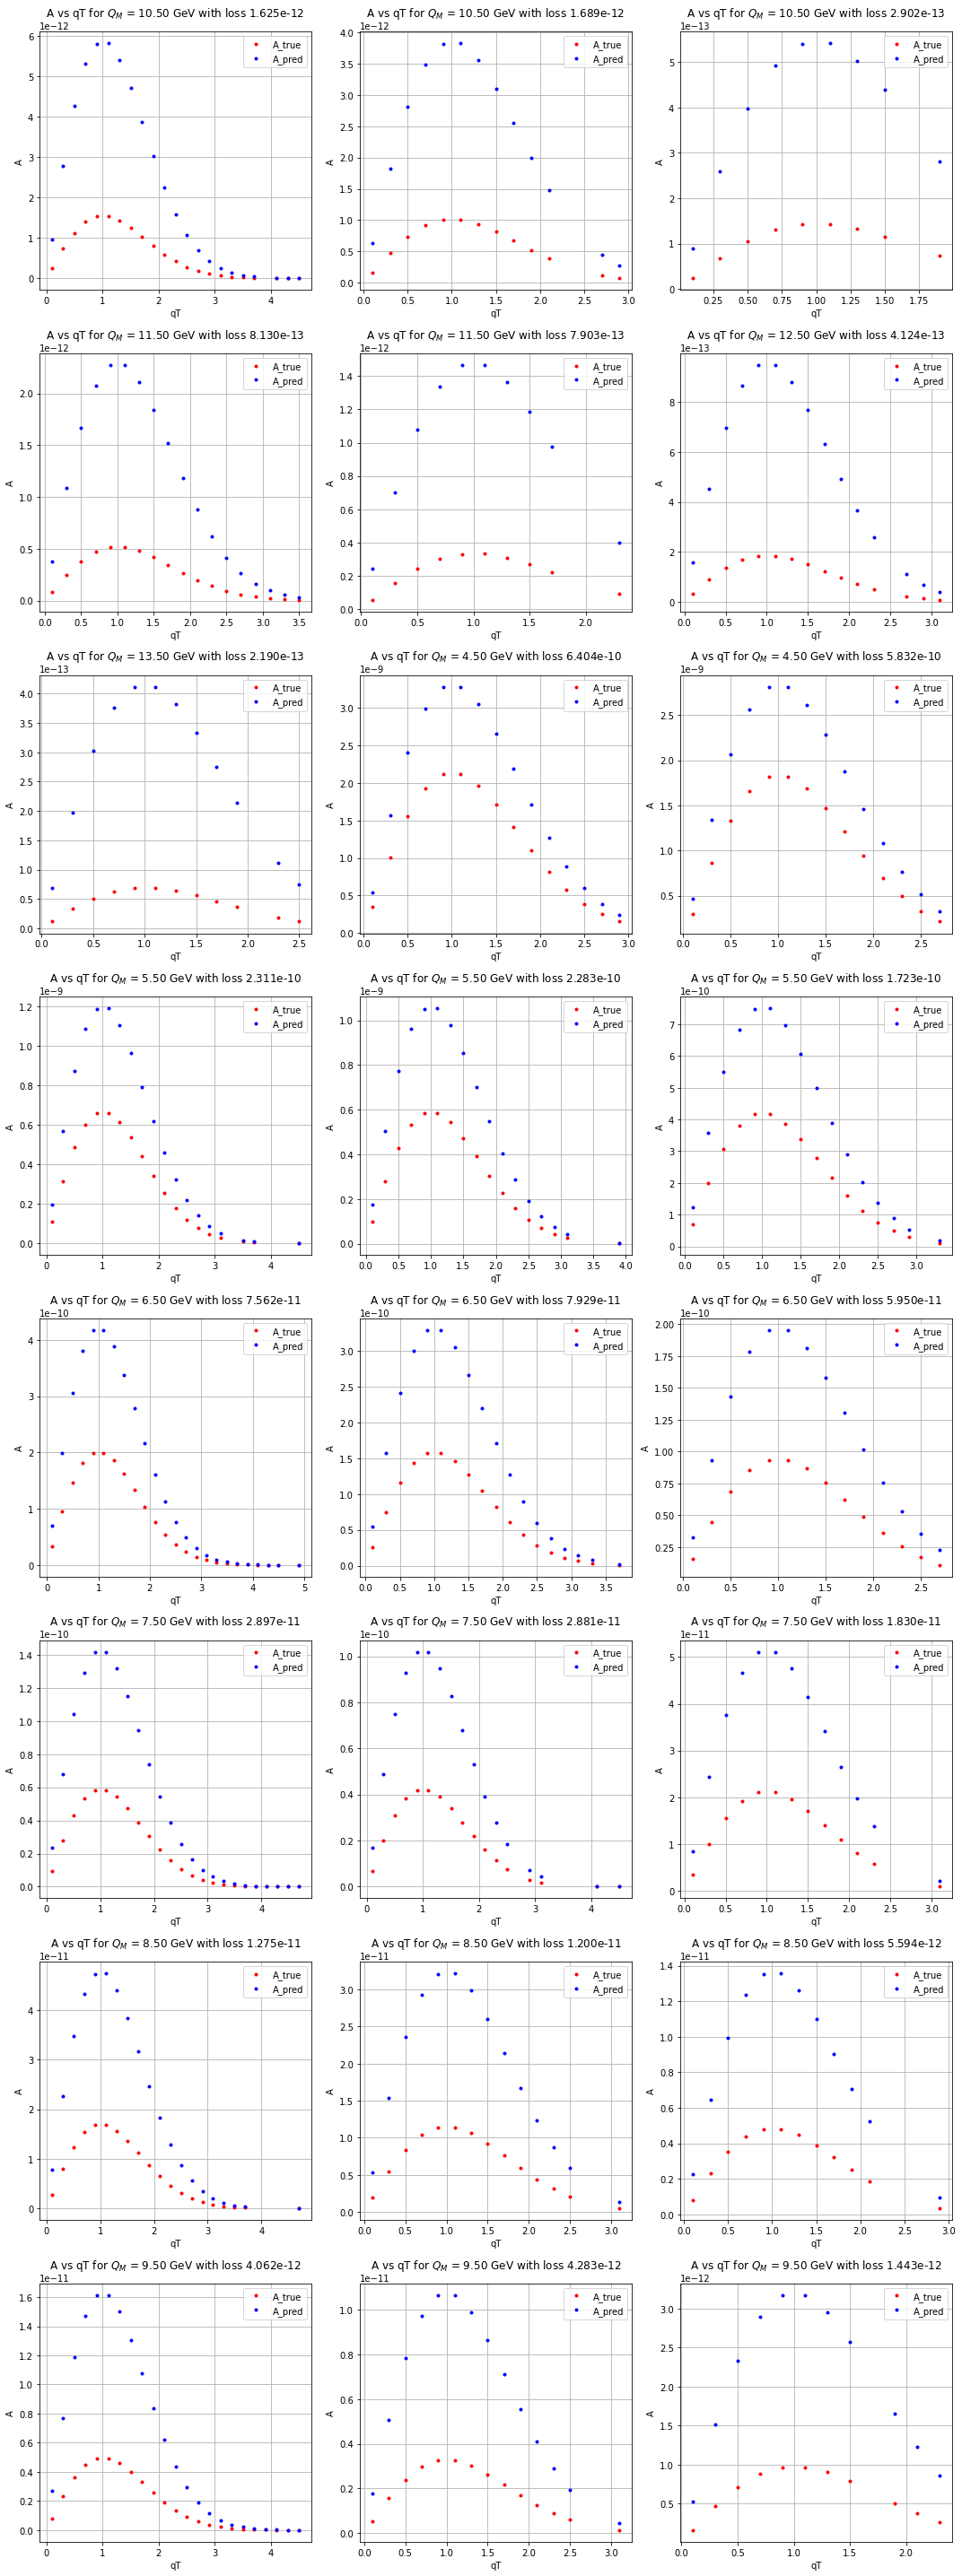

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


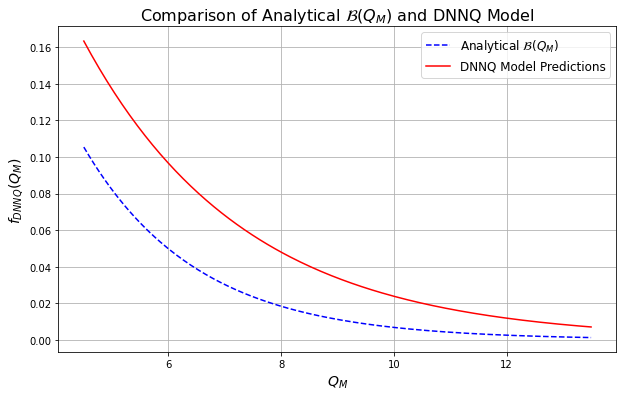

Results saved successfully!


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import lhapdf
from tensorflow.keras.models import load_model


def create_folders(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created successfully!")
    else:
        print(f"Folder '{folder_name}' already exists!")

results_folder = 'Results_from_the_Model'
create_folders(results_folder)

NNPDF4_nlo = lhapdf.mkPDF('NNPDF40_nlo_as_01180')

alpha = 1 / 137  # Fine-structure constant


models_folder = 'Models_withLHAPDF'
dnnQ_model = load_model(f"{models_folder}/DNNQ_model.h5")
dnnQ_model.compile(optimizer="adam", loss="mse")


pseudo_df = pd.read_csv("pseudodataE288_BQM.csv")


def pdf(pdfset, flavor, x, QQ):
    """ Function to retrieve PDF values """
    return pdfset.xfxQ(flavor, x, QQ)


def compute_A(x1, x2, qT, QM):
    """ Compute theoretical A values using the loaded model """
    f_u_x1 = pdf(NNPDF4_nlo, 2, x1, QM)
    f_ubar_x2 = pdf(NNPDF4_nlo, -2, x2, QM)
    f_u_x2 = pdf(NNPDF4_nlo, 2, x2, QM)
    f_ubar_x1 = pdf(NNPDF4_nlo, -2, x1, QM)

    Sk_contribution = (1 / 2) * np.pi * np.exp(-qT ** 2 / 2)
    
    QM_input = QM.reshape(-1, 1)
    fDNN_contribution = dnnQ_model.predict(QM_input, verbose=0).flatten()

    ux1ubarx2_term = x1 * x2 * f_u_x1 * f_ubar_x2 * Sk_contribution
    ubarx1ux2_term = x2 * x1 * f_u_x2 * f_ubar_x1 * Sk_contribution
    FUU = (ux1ubarx2_term + ubarx1ux2_term) * fDNN_contribution
    cross_section = FUU * qT * ((4 * np.pi * alpha) ** 2) / (9 * QM ** 3)

    return cross_section



pseudo_df["unique_group"] = (
    pseudo_df["QM"].astype(str) + "_" + pseudo_df["x1"].astype(str) + "_" + pseudo_df["x2"].astype(str)
)
groups = pseudo_df.groupby("unique_group")
n_groups = groups.ngroups
ncols = 3
nrows = (n_groups + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()


for idx, (group_name, group_df) in enumerate(groups):
    qT = group_df['qT'].values
    QM = group_df['QM'].values
    x1 = group_df['x1'].values
    x2 = group_df['x2'].values
    A_true = group_df['A'].values

    A_pred = compute_A(x1, x2, qT, QM)
    temp_loss = loss_A(A_true, x1, x2, qT, QM)

    axes[idx].plot(qT, A_true, '.', color='red', label='A_true')
    axes[idx].plot(qT, A_pred, '.', color='blue', label='A_pred')
    #axes[idx].set_title(f'A vs qT for $Q_M$ = {QM[0]:.2f} GeV')
    axes[idx].set_title(f'A vs qT for $Q_M$ = {QM[0]:.2f} GeV with loss {temp_loss:.3e}')
    axes[idx].set_xlabel('qT')
    axes[idx].set_ylabel('A')
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig(f"{results_folder}/QM_subplots_with_predictions_with_LHAPDF.pdf")
plt.show()



def fDNNQ(QM, b=0.5):
    """ Analytical function for fDNNQ(QM) """
    return np.exp(-b * QM)

QM_values = np.linspace(pseudo_df['QM'].min(), pseudo_df['QM'].max(), 200)
QM_tensor = QM_values.reshape(-1, 1)
dnnQ_predictions = dnnQ_model.predict(QM_tensor).flatten()
fDNNQ_values = fDNNQ(QM_values)

plt.figure(figsize=(10, 6))
plt.plot(QM_values, fDNNQ_values, label=r'Analytical $\mathcal{B}(Q_M)$', linestyle='--', color='blue')
plt.plot(QM_values, dnnQ_predictions, label='DNNQ Model Predictions', linestyle='-', color='red')
plt.xlabel(r'$Q_M$', fontsize=14)
plt.ylabel(r'$f_{DNNQ}(Q_M)$', fontsize=14)
plt.title('Comparison of Analytical $\mathcal{B}(Q_M)$ and DNNQ Model', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig(f"{results_folder}/QM_comparison_plot.pdf")
plt.show()


pseudo_df["A_pred"] = compute_A(pseudo_df['x1'].values, pseudo_df['x2'].values, pseudo_df['qT'].values, pseudo_df['QM'].values)
pseudo_df.to_csv(f"{results_folder}/Results_pseudodataE288_with_LHAPDF.csv", index=False)

print("Results saved successfully!")
